# Paso 1: Análisis Exploratorio de Datos (EDA)

In [ ]:

from IPython.display import display

try:
    ORIG = DF_ORIG_COLS
except NameError:
    ORIG = list(df.columns) if 'df' in globals() else None

if 'df' not in globals():
    print('df no está definido. Ejecuta las celdas de carga/limpieza antes de este reporte.')
else:
    print('Columnas originales:', ORIG if ORIG is not None else '(no disponible; ejecuta 2.1 primero)')
    print('Columnas actuales  :', list(df.columns))
    miss = df.isnull().sum()
    rem = miss[miss>0].sort_values(ascending=False).head(10)
    print('\nTop faltantes:')
    if rem.empty:
        print('(sin faltantes)')
    else:
        print(rem)
    print('\nDtypes:')
    print(df.dtypes)
    display(df.head(3))


### Preguntas y Respuestas — Hallazgos del Paso 1 (EDA)

**Q: ¿Qué variables parecen más prometedoras?**

**A:**
- CryoSleep: fuerte asociación con Transportado (True → ↑ probabilidad).
- Gastos a bordo (RoomService, FoodCourt, ShoppingMall, Spa, VRDeck) y derivadas: `TotalSpend` y bandera `SpendZero`.
- Cabin → `Deck` y `Side`: muestran diferencias de tasa por ubicación.
- HomePlanet y Destination: categorías con tasas de transporte distintas.
- Age (en bins): tendencia a mayor transporte en edades más bajas.
- GroupID (derivado de PassengerId): miembros del mismo grupo suelen compartir etiqueta.
- VIP: efecto débil o nulo en general.

**Q: ¿Observas alguna correlación interesante?**

**A:**
- Fuerte colinealidad entre los gastos entre sí y con `TotalSpend`; evitar duplicidad de señales.
- CryoSleep ≈ gastos 0; inconsistencias sugieren ruido o necesidad de imputación.
- `SpendZero` correlaciona positivamente con Transportado.
- Diferencias claras por `Deck/Side` (algunos decks/lados ↑, otros ↓).
- Posible interacción HomePlanet × Destination que cambia las tasas.
- Gradiente leve por edad (más jóvenes → ↑ Transportado).

> Ajusta estas conclusiones con las tasas exactas que viste en tus gráficos.


Analisis Exploratorio de Datos

In [ ]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración: mostrar todas las columnas en los DataFrames
pd.set_option('display.max_columns', None)


## 1.1 Carga y Exploración Inicial de Datos


In [ ]:
# Cargar el dataset
df = pd.read_csv('registros_entrenamiento-2.csv')

print("=" * 60)
print("INFORMACIÓN BÁSICA DEL DATASET")
print("=" * 60)
print(f"\nDimensiones del dataset: {df.shape[0]} filas x {df.shape[1]} columnas")
print(f"\nPrimeras 5 filas:")
display(df.head())

print("\n" + "=" * 60)
print("TIPOS DE DATOS")
print("=" * 60)
print(df.dtypes)


INFORMACIÓN BÁSICA DEL DATASET

Dimensiones del dataset: 8000 filas x 14 columnas

Primeras 5 filas:


,IdPasajero,PlanetaOrigen,SuenoCriogenico,Cabina,Destino,Edad,ServicioVIP,ServicioHabitacion,Cafeteria,CentroComercial,Spa,CubiertaVR,Transportado,Iniciales
0,004D8BSQ,NaN,False,C/268/S,TRAPPIST-1e,27.0,False,0.0,63.0,8.0,129.0,2960.0,False,YUW
1,009TL1XF,Europa,False,C/258/P,55 Cancri e,18.0,False,0.0,3492.0,0.0,506.0,8.0,True,SFW
2,00A9QC49,Europa,False,A/30/S,TRAPPIST-1e,44.0,True,1409.0,910.0,17.0,1452.0,3782.0,False,POY
3,00BJM5YI,Earth,False,E/24/P,TRAPPIST-1e,48.0,False,0.0,111.0,0.0,1508.0,0.0,False,ZIT
4,00DQRZAR,Mars,False,F/1550/P,TRAPPIST-1e,68.0,True,523.0,0.0,859.0,201.0,782.0,False,TJJ



TIPOS DE DATOS
IdPasajero             object
PlanetaOrigen          object
SuenoCriogenico        object
Cabina                 object
Destino                object
Edad                  float64
ServicioVIP            object
ServicioHabitacion    float64
Cafeteria             float64
CentroComercial       float64
Spa                   float64
CubiertaVR            float64
Transportado             bool
Iniciales              object
dtype: object


ANÁLISIS DE VALORES FALTANTES

Columnas con valores faltantes:



,Columna,Valores Faltantes,Porcentaje (%)
SuenoCriogenico,SuenoCriogenico,197,2.46
CentroComercial,CentroComercial,191,2.39
ServicioVIP,ServicioVIP,188,2.35
Cabina,Cabina,179,2.24
PlanetaOrigen,PlanetaOrigen,177,2.21
CubiertaVR,CubiertaVR,174,2.17
Spa,Spa,173,2.16
Edad,Edad,165,2.06
Destino,Destino,163,2.04
ServicioHabitacion,ServicioHabitacion,161,2.01


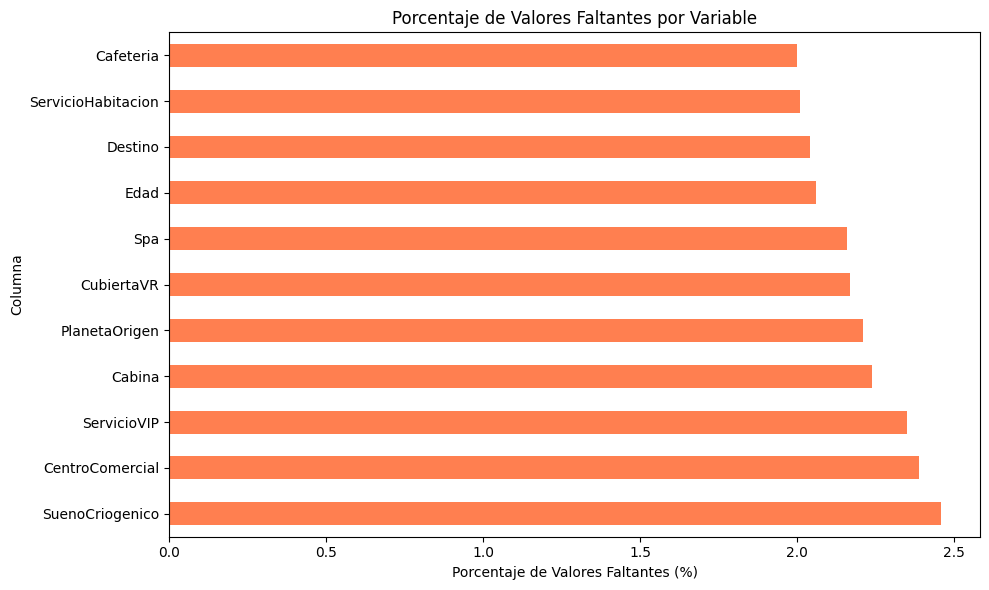

In [ ]:
# Análisis de valores faltantes
print("=" * 60)
print("ANÁLISIS DE VALORES FALTANTES")
print("=" * 60)

missing_data = pd.DataFrame({
    'Columna': df.columns,
    'Valores Faltantes': df.isnull().sum(),
    'Porcentaje (%)': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_data = missing_data[missing_data['Valores Faltantes'] > 0].sort_values('Valores Faltantes', ascending=False)

if len(missing_data) > 0:
    print(f"\nColumnas con valores faltantes:\n")
    display(missing_data)
    
    # Visualización de valores faltantes
    plt.figure(figsize=(10, 6))
    missing_data.set_index('Columna')['Porcentaje (%)'].plot(kind='barh', color='coral')
    plt.xlabel('Porcentaje de Valores Faltantes (%)')
    plt.title('Porcentaje de Valores Faltantes por Variable')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo hay valores faltantes en el dataset")


In [ ]:
# Estadísticas descriptivas
print("=" * 60)
print("ESTADÍSTICAS DESCRIPTIVAS - VARIABLES NUMÉRICAS")
print("=" * 60)
display(df.describe())

print("\n" + "=" * 60)
print("ESTADÍSTICAS DESCRIPTIVAS - VARIABLES CATEGÓRICAS")
print("=" * 60)
display(df.describe(include=['object', 'bool']))


ESTADÍSTICAS DESCRIPTIVAS - VARIABLES NUMÉRICAS


,Edad,ServicioHabitacion,Cafeteria,CentroComercial,Spa,CubiertaVR
count,7835.000000,7839.000000,7840.000000,7809.000000,7827.000000,7826.000000
mean,28.898532,223.319301,461.104592,171.726085,320.425067,308.133785
std,14.539789,664.351288,1620.003645,597.058475,1159.805503,1152.419633
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,82.000000,26.000000,66.000000,48.750000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000



ESTADÍSTICAS DESCRIPTIVAS - VARIABLES CATEGÓRICAS


,IdPasajero,PlanetaOrigen,SuenoCriogenico,Cabina,Destino,ServicioVIP,Transportado,Iniciales
count,8000,7823,7803,7821,7837,7812,8000,8000
unique,8000,3,2,6124,3,2,2,6436
top,004D8BSQ,Earth,False,G/109/P,TRAPPIST-1e,False,True,IET
freq,1,4246,5020,7,5441,7633,4013,5


## 1.2 Análisis de la Variable Objetivo: Transportado


DISTRIBUCIÓN DE LA VARIABLE OBJETIVO: TRANSPORTADO

Conteo:
Transportado
True     4013
False    3987
Name: count, dtype: int64

Porcentaje:
Transportado
True     50.16
False    49.84
Name: proportion, dtype: float64


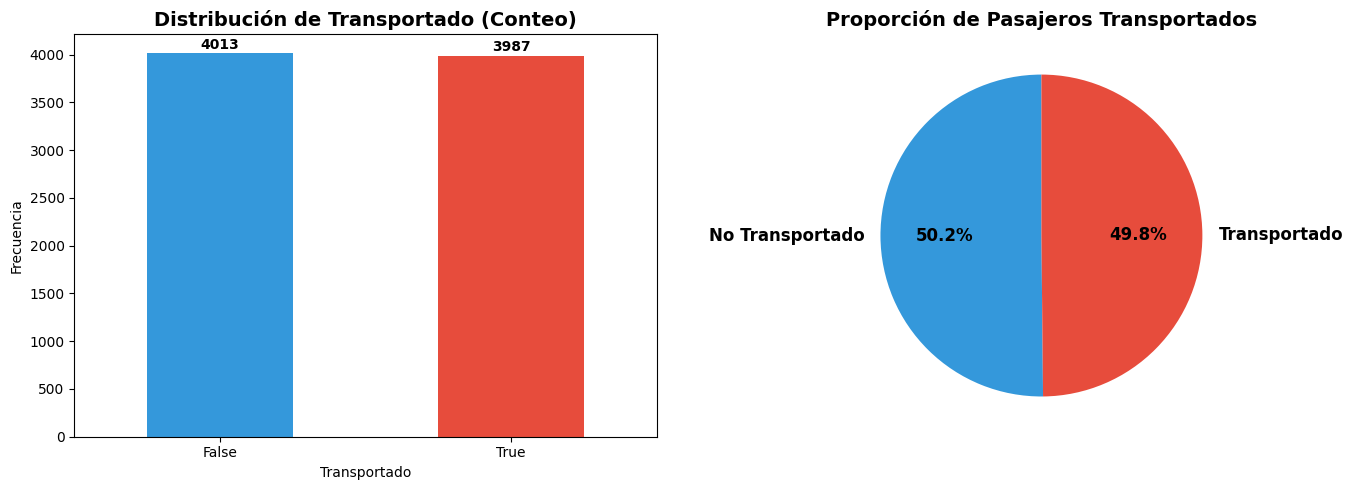


✓ Balance de clases: 0.99 (1.0 = perfectamente balanceado)


In [ ]:
# Análisis de la variable objetivo
print("=" * 60)
print("DISTRIBUCIÓN DE LA VARIABLE OBJETIVO: TRANSPORTADO")
print("=" * 60)

target_counts = df['Transportado'].value_counts()
target_pct = df['Transportado'].value_counts(normalize=True) * 100

print(f"\nConteo:")
print(target_counts)
print(f"\nPorcentaje:")
print(target_pct.round(2))

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
target_counts.plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c'])
axes[0].set_title('Distribución de Transportado (Conteo)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Transportado')
axes[0].set_ylabel('Frecuencia')
axes[0].set_xticklabels(['False', 'True'], rotation=0)

# Añadir valores en las barras
for i, v in enumerate(target_counts):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Gráfico de pastel
colors = ['#3498db', '#e74c3c']
axes[1].pie(target_counts, labels=['No Transportado', 'Transportado'], autopct='%1.1f%%', 
            colors=colors, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Proporción de Pasajeros Transportados', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Balance de clases
balance = target_counts.min() / target_counts.max()
print(f"\n{'⚠️' if balance < 0.8 else '✓'} Balance de clases: {balance:.2f} (1.0 = perfectamente balanceado)")


## 1.3 Distribución de Variables Numéricas


Variables numéricas a analizar: ['Edad', 'ServicioHabitacion', 'Cafeteria', 'CentroComercial', 'Spa', 'CubiertaVR']



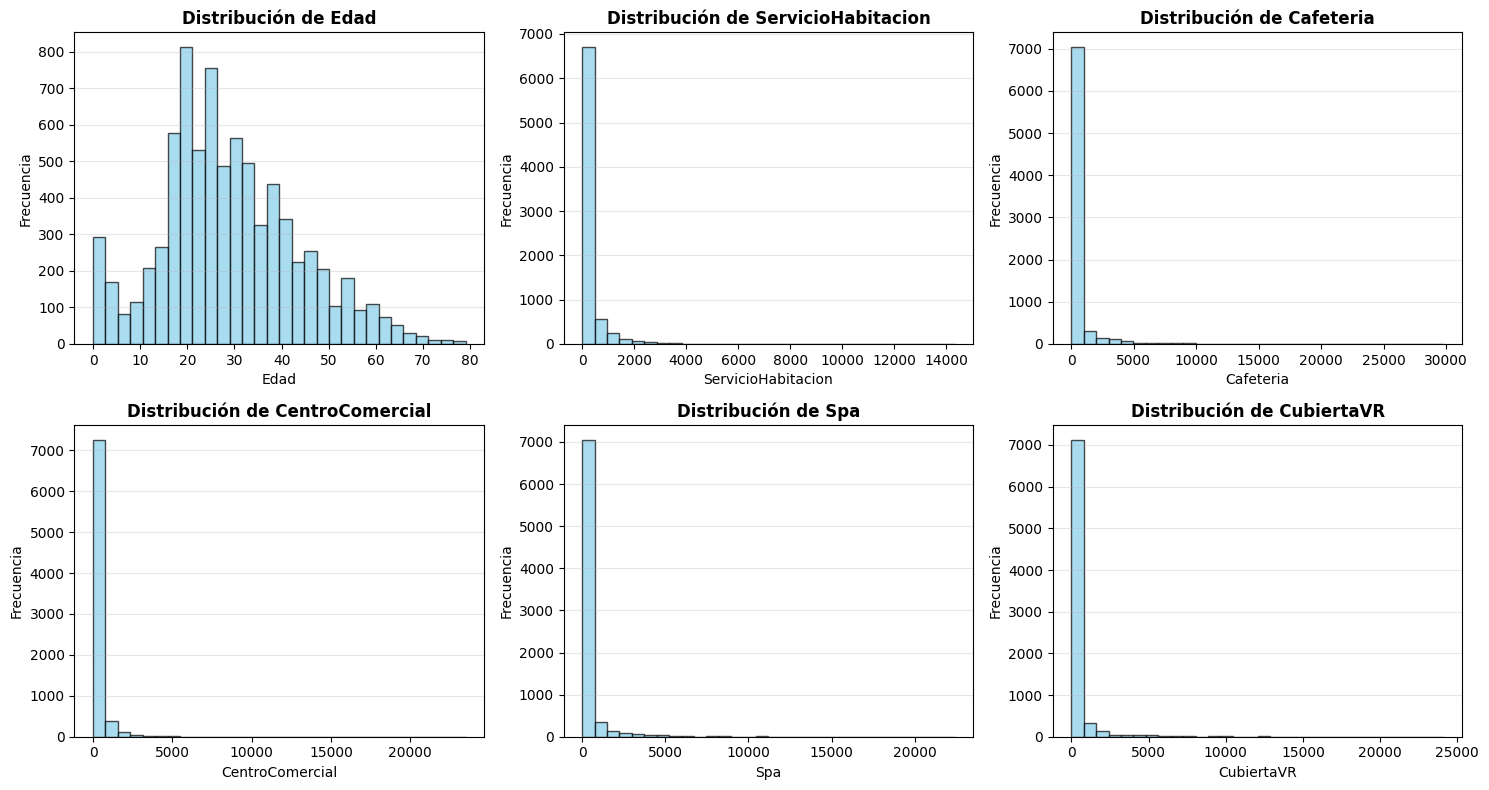

In [ ]:
# Identificar variables numéricas (excluyendo el ID)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'IdPasajero' in df.columns:
    numeric_cols = [col for col in numeric_cols if col != 'IdPasajero']

print(f"Variables numéricas a analizar: {numeric_cols}\n")

# Histogramas de variables numéricas
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten() if len(numeric_cols) > 1 else [axes]

for idx, col in enumerate(numeric_cols):
    if idx < len(axes):
        axes[idx].hist(df[col].dropna(), bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'Distribución de {col}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frecuencia')
        axes[idx].grid(axis='y', alpha=0.3)

# Ocultar ejes vacíos
for idx in range(len(numeric_cols), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


## 1.4 Distribución de Variables Categóricas


Variables categóricas a analizar: ['PlanetaOrigen', 'SuenoCriogenico', 'Destino', 'ServicioVIP']



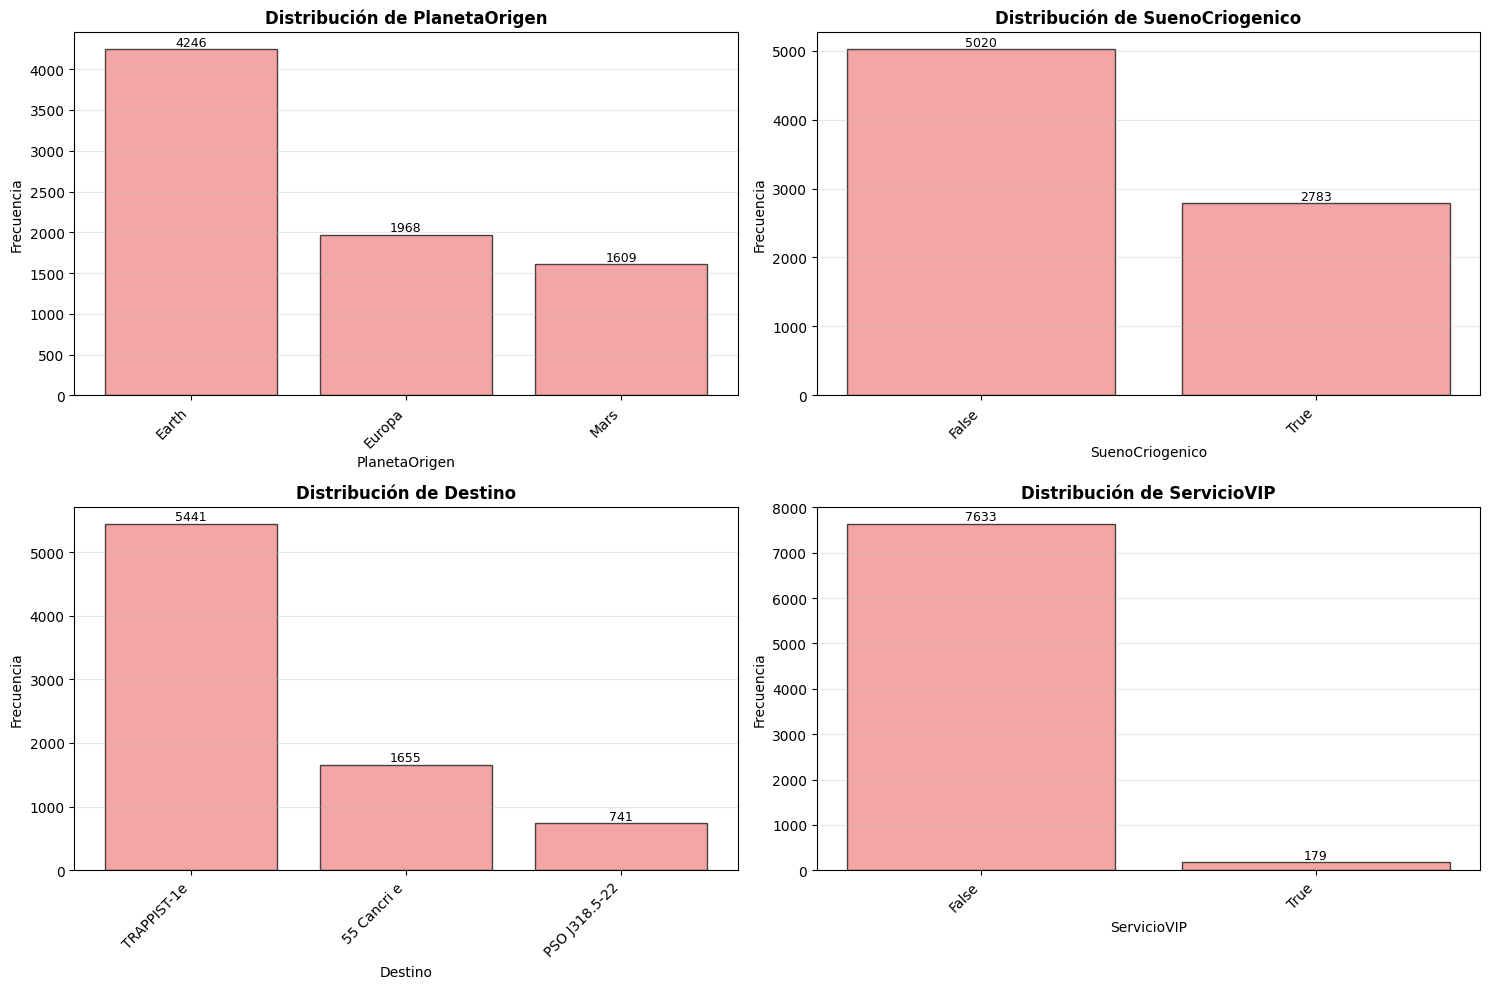

In [ ]:
# Identificar variables categóricas importantes (excluyendo ID, Iniciales, Cabina que es muy específica)
categorical_cols = ['PlanetaOrigen', 'SuenoCriogenico', 'Destino', 'ServicioVIP']
categorical_cols = [col for col in categorical_cols if col in df.columns]

print(f"Variables categóricas a analizar: {categorical_cols}\n")

# Gráficos de barras para variables categóricas
n_cols = 2
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten() if len(categorical_cols) > 1 else [axes]

for idx, col in enumerate(categorical_cols):
    if idx < len(axes):
        value_counts = df[col].value_counts()
        axes[idx].bar(range(len(value_counts)), value_counts.values, color='lightcoral', edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'Distribución de {col}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frecuencia')
        axes[idx].set_xticks(range(len(value_counts)))
        axes[idx].set_xticklabels(value_counts.index, rotation=45, ha='right')
        axes[idx].grid(axis='y', alpha=0.3)
        
        # Añadir valores en las barras
        for i, v in enumerate(value_counts.values):
            axes[idx].text(i, v + max(value_counts.values) * 0.01, str(v), ha='center', fontsize=9)

# Ocultar ejes vacíos
for idx in range(len(categorical_cols), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


## 1.5 Correlación entre Variables Numéricas


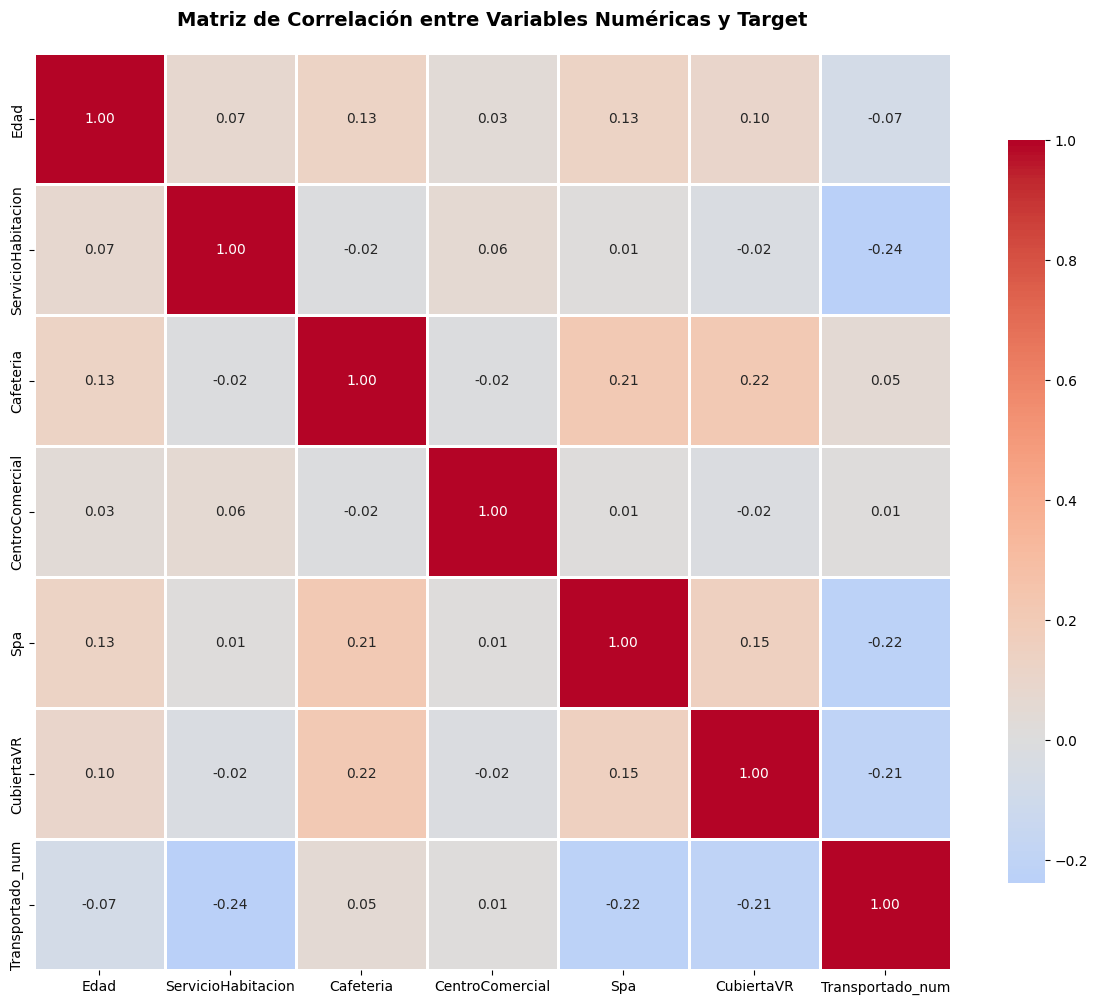

CORRELACIÓN CON LA VARIABLE OBJETIVO (TRANSPORTADO)

Variables ordenadas por correlación con Transportado:
Cafeteria             0.051358
CentroComercial       0.010145
Edad                 -0.073805
CubiertaVR           -0.205830
Spa                  -0.222618
ServicioHabitacion   -0.238996
Name: Transportado_num, dtype: float64


In [ ]:
# Matriz de correlación
# Convertir variable objetivo a numérica para la correlación
df_corr = df.copy()
df_corr['Transportado_num'] = df_corr['Transportado'].map({True: 1, False: 0})

# Seleccionar solo variables numéricas para correlación
numeric_cols_corr = df_corr.select_dtypes(include=[np.number]).columns.tolist()
# Excluir ID si existe
numeric_cols_corr = [col for col in numeric_cols_corr if 'Id' not in col]

correlation_matrix = df_corr[numeric_cols_corr].corr()

# Mapa de calor
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación entre Variables Numéricas y Target', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Correlaciones con la variable objetivo
print("=" * 60)
print("CORRELACIÓN CON LA VARIABLE OBJETIVO (TRANSPORTADO)")
print("=" * 60)
target_corr = correlation_matrix['Transportado_num'].drop('Transportado_num').sort_values(ascending=False)
print("\nVariables ordenadas por correlación con Transportado:")
print(target_corr)


## 1.6 Relación entre Variables y el Target


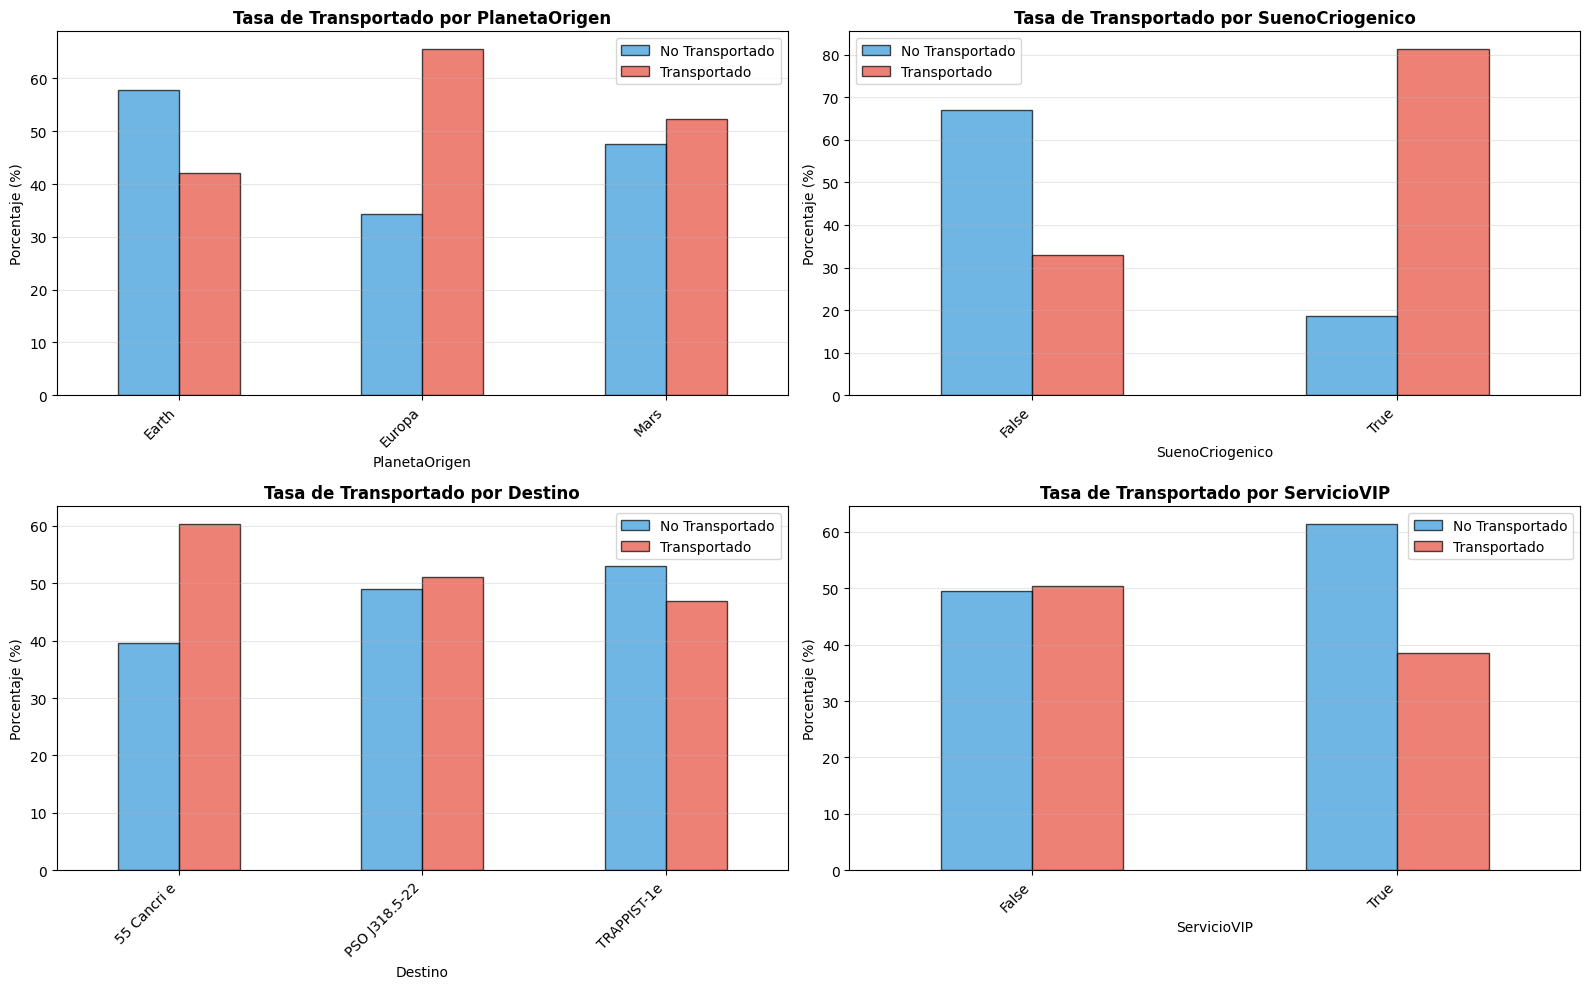

In [ ]:
# Relación entre variables categóricas y el target
categorical_for_analysis = ['PlanetaOrigen', 'SuenoCriogenico', 'Destino', 'ServicioVIP']
categorical_for_analysis = [col for col in categorical_for_analysis if col in df.columns]

n_cols = 2
n_rows = (len(categorical_for_analysis) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 5))
axes = axes.flatten() if len(categorical_for_analysis) > 1 else [axes]

for idx, col in enumerate(categorical_for_analysis):
    if idx < len(axes):
        # Crear tabla cruzada normalizada
        ct = pd.crosstab(df[col], df['Transportado'], normalize='index') * 100
        ct.plot(kind='bar', ax=axes[idx], color=['#3498db', '#e74c3c'], alpha=0.7, edgecolor='black')
        axes[idx].set_title(f'Tasa de Transportado por {col}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Porcentaje (%)')
        axes[idx].legend(['No Transportado', 'Transportado'], loc='best')
        axes[idx].grid(axis='y', alpha=0.3)
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')

# Ocultar ejes vacíos
for idx in range(len(categorical_for_analysis), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


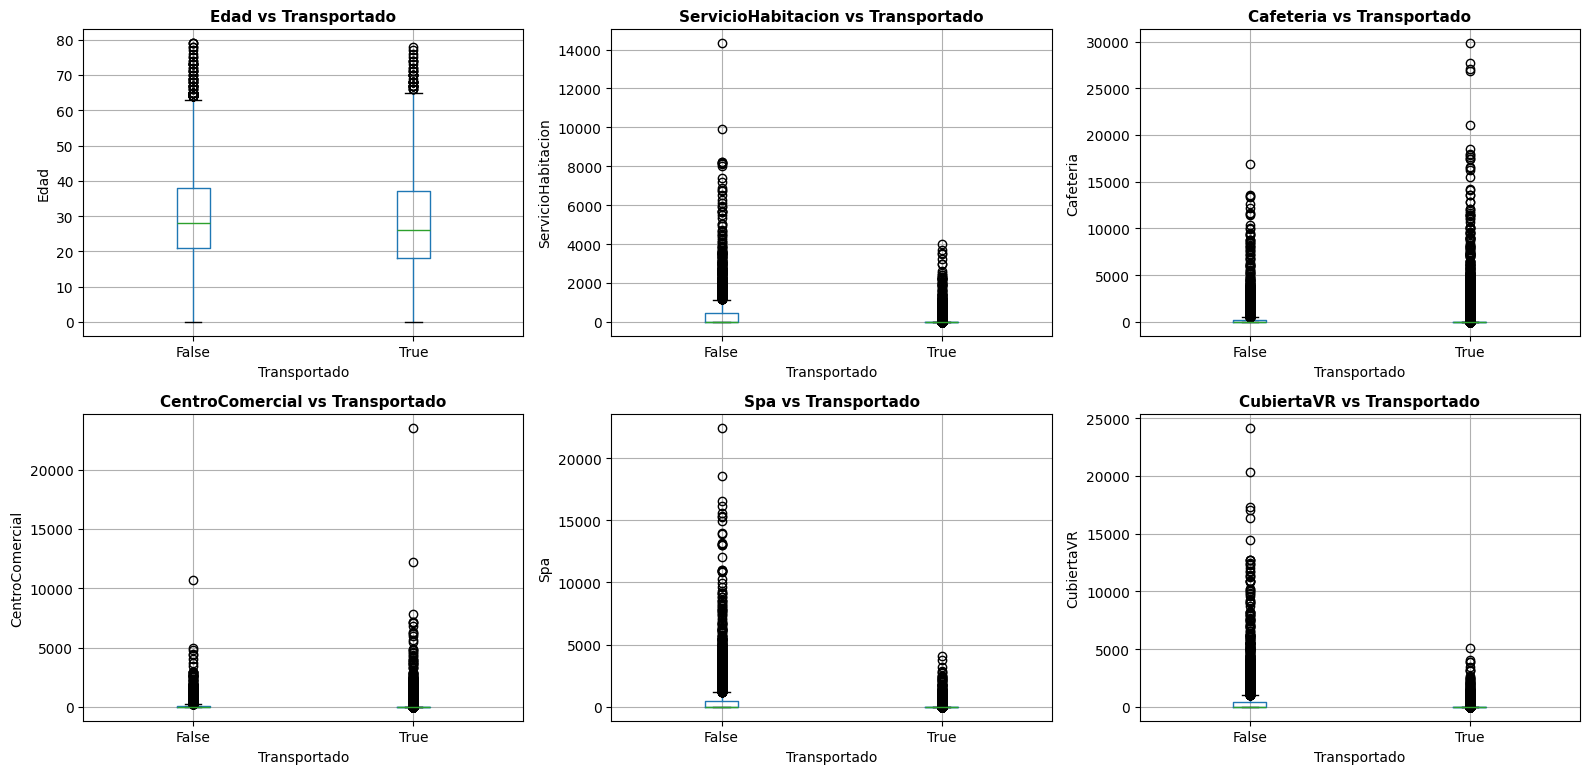

In [ ]:
# Boxplots de variables numéricas vs Transportado (para las más importantes)
# Seleccionar variables numéricas relevantes (excluir ID)
numeric_for_boxplot = [col for col in numeric_cols[:6] if col in df.columns]  # Tomar las primeras 6

n_cols = 3
n_rows = (len(numeric_for_boxplot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten() if len(numeric_for_boxplot) > 1 else [axes]

for idx, col in enumerate(numeric_for_boxplot):
    if idx < len(axes):
        df_plot = df[[col, 'Transportado']].dropna()
        df_plot.boxplot(column=col, by='Transportado', ax=axes[idx])
        axes[idx].set_title(f'{col} vs Transportado', fontsize=11, fontweight='bold')
        axes[idx].set_xlabel('Transportado')
        axes[idx].set_ylabel(col)
        plt.sca(axes[idx])
        plt.xticks([1, 2], ['False', 'True'])

# Ocultar ejes vacíos
for idx in range(len(numeric_for_boxplot), len(axes)):
    axes[idx].axis('off')

plt.suptitle('')  # Remover el título automático de pandas
plt.tight_layout()
plt.show()


## 1.7 Hallazgos Clave del Análisis Exploratorio


In [ ]:
# Resumen de hallazgos
print("=" * 80)
print(" " * 20 + "RESUMEN DE HALLAZGOS DEL EDA")
print("=" * 80)

print("\n📊 1. INFORMACIÓN GENERAL:")
print(f"   • Total de registros: {len(df):,}")
print(f"   • Total de variables: {len(df.columns)}")
print(f"   • Variables numéricas: {len(numeric_cols)}")
print(f"   • Variables categóricas: {len(df.select_dtypes(include=['object', 'bool']).columns)}")

print("\n⚠️  2. CALIDAD DE DATOS:")
missing_summary = df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0]
if len(missing_summary) > 0:
    print(f"   • Columnas con valores faltantes: {len(missing_summary)}")
    for col, count in missing_summary.items():
        pct = (count / len(df)) * 100
        print(f"     - {col}: {count} ({pct:.1f}%)")
else:
    print("   • ✓ No hay valores faltantes")

print("\n🎯 3. VARIABLE OBJETIVO (Transportado):")
target_dist = df['Transportado'].value_counts(normalize=True) * 100
print(f"   • False (No transportado): {target_dist[False]:.1f}%")
print(f"   • True (Transportado): {target_dist[True]:.1f}%")
balance = min(target_dist) / max(target_dist)
if balance >= 0.8:
    print(f"   • ✓ Dataset balanceado (ratio: {balance:.2f})")
elif balance >= 0.6:
    print(f"   • ⚠️  Ligero desbalance (ratio: {balance:.2f})")
else:
    print(f"   • ⚠️  Dataset desbalanceado (ratio: {balance:.2f}) - considerar técnicas de balanceo")

print("\n🔍 4. VARIABLES MÁS PROMETEDORAS:")
# Basado en correlaciones
if 'Transportado_num' in df_corr.columns:
    top_corr = correlation_matrix['Transportado_num'].drop('Transportado_num').abs().sort_values(ascending=False).head(5)
    print("   Basado en correlación con el target:")
    for var, corr_val in top_corr.items():
        print(f"     - {var}: {corr_val:.3f}")

print("\n💡 5. CORRELACIONES INTERESANTES:")
# Encontrar correlaciones altas entre variables (no con el target)
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if correlation_matrix.columns[i] != 'Transportado_num' and correlation_matrix.columns[j] != 'Transportado_num':
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) > 0.5:  # Correlación significativa
                corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_value))

if corr_pairs:
    print("   Correlaciones fuertes entre variables (|r| > 0.5):")
    for var1, var2, corr_val in sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:5]:
        print(f"     - {var1} ↔ {var2}: {corr_val:.3f}")
else:
    print("   • No se encontraron correlaciones muy fuertes entre variables predictoras")

print("\n📝 6. OBSERVACIONES ADICIONALES:")
# Análisis de SuenoCriogenico si existe
if 'SuenoCriogenico' in df.columns:
    cryo_transport = df.groupby('SuenoCriogenico')['Transportado'].value_counts(normalize=True).unstack() * 100
    if True in cryo_transport.index and True in cryo_transport.columns:
        cryo_effect = cryo_transport.loc[True, True] - cryo_transport.loc[False, True]
        print(f"   • Sueño criogénico parece tener un efecto de {cryo_effect:+.1f}% en la tasa de transporte")

# Análisis de edad si existe
if 'Edad' in df.columns:
    df_edad_clean = df[df['Edad'].notna()]
    edad_transport = df_edad_clean.groupby('Transportado')['Edad'].mean()
    if len(edad_transport) == 2:
        edad_diff = edad_transport[True] - edad_transport[False]
        print(f"   • Edad promedio de transportados: {edad_transport[True]:.1f} años")
        print(f"   • Edad promedio de no transportados: {edad_transport[False]:.1f} años")


                    RESUMEN DE HALLAZGOS DEL EDA

📊 1. INFORMACIÓN GENERAL:
   • Total de registros: 8,000
   • Total de variables: 14
   • Variables numéricas: 6
   • Variables categóricas: 8

⚠️  2. CALIDAD DE DATOS:
   • Columnas con valores faltantes: 11
     - PlanetaOrigen: 177 (2.2%)
     - SuenoCriogenico: 197 (2.5%)
     - Cabina: 179 (2.2%)
     - Destino: 163 (2.0%)
     - Edad: 165 (2.1%)
     - ServicioVIP: 188 (2.4%)
     - ServicioHabitacion: 161 (2.0%)
     - Cafeteria: 160 (2.0%)
     - CentroComercial: 191 (2.4%)
     - Spa: 173 (2.2%)
     - CubiertaVR: 174 (2.2%)

🎯 3. VARIABLE OBJETIVO (Transportado):
   • False (No transportado): 49.8%
   • True (Transportado): 50.2%
   • ✓ Dataset balanceado (ratio: 0.99)

🔍 4. VARIABLES MÁS PROMETEDORAS:
   Basado en correlación con el target:
     - ServicioHabitacion: 0.239
     - Spa: 0.223
     - CubiertaVR: 0.206
     - Edad: 0.074
     - Cafeteria: 0.051

💡 5. CORRELACIONES INTERESANTES:
   • No se encontraron correlacione

# Paso 2: Limpieza de Datos e Ingeniería de Características

### 2.1 Setup y normalización de tipos

In [ ]:

# Setup
import numpy as np
import pandas as pd
print('Registros:', len(df), '| Columnas:', len(df.columns))
DF_ORIG_COLS = df.columns.tolist()

# Normalizar booleanos
bool_maps = {True: True, False: False, 'True': True, 'False': False, 'TRUE': True, 'FALSE': False, 1: True, 0: False}
for col in ['SuenoCriogenico', 'ServicioVIP', 'Transportado']:
    if col in df.columns:
        df[col] = df[col].map(bool_maps).astype('boolean')
print('✓ Booleanos normalizados')


### 2.2 Parseo de Cabina → Deck/Num/Side

In [ ]:

if 'Cabina' in df.columns:
    parts = df['Cabina'].astype('string').str.split('/', expand=True)
    if parts.shape[1] >= 1:
        df['Deck'] = parts[0]
    if parts.shape[1] >= 2:
        df['CabinaNum'] = pd.to_numeric(parts[1], errors='coerce')
    if parts.shape[1] >= 3:
        df['Side'] = parts[2]
    print('✓ Cabina parseada a Deck/CabinaNum/Side')
else:
    print('↷ Columna Cabina no encontrada')


### 2.3 Imputación de gastos y TotalSpend

In [ ]:

gasto_cols = [c for c in ['ServicioHabitacion','Cafeteria','CentroComercial','Spa','CubiertaVR'] if c in df.columns]
for c in gasto_cols:
    df[c] = df[c].fillna(0)

df['TotalSpend'] = df[gasto_cols].sum(axis=1) if gasto_cols else 0
print('✓ Gastos imputados a 0 y TotalSpend calculado')


### 2.4 Regla de negocio: CryoSleep ⇒ gastos = 0

In [ ]:

if 'SuenoCriogenico' in df.columns and len(gasto_cols):
    mask = df['SuenoCriogenico'] == True
    before = df.loc[mask, 'TotalSpend'].sum()
    df.loc[mask, gasto_cols] = 0
    df.loc[mask, 'TotalSpend'] = 0
    after = df.loc[mask, 'TotalSpend'].sum()
    print(f'✓ CryoSleep aplicado: TotalSpend (antes→después) {before} → {after}')
else:
    print('↷ No se aplicó regla (faltan columnas)')


### 2.5 Imputación de SuenoCriogenico por TotalSpend + moda

In [ ]:

if 'SuenoCriogenico' in df.columns:
    na = df['SuenoCriogenico'].isna()
    n_before = na.sum()
    df.loc[na & (df['TotalSpend'] == 0), 'SuenoCriogenico'] = True
    df.loc[na & (df['TotalSpend'] > 0), 'SuenoCriogenico'] = False
    if df['SuenoCriogenico'].isna().any():
        moda = df['SuenoCriogenico'].mode(dropna=True)
        if len(moda):
            df['SuenoCriogenico'] = df['SuenoCriogenico'].fillna(moda.iloc[0])
    print('✓ SuenoCriogenico imputado; faltantes iniciales:', int(n_before), '→ actuales:', int(df['SuenoCriogenico'].isna().sum()))


### 2.6 Crear SpendZero

In [ ]:

df['SpendZero'] = (df['TotalSpend'] == 0)
print('✓ SpendZero creada')


### 2.7 Imputación de Deck/Side y CabinaNum

In [ ]:

for col, fill in [('Deck','Unknown'), ('Side','Unknown')]:
    if col in df.columns:
        df[col] = df[col].fillna(fill)
if 'CabinaNum' in df.columns and 'Deck' in df.columns:
    df['CabinaNum'] = df.groupby('Deck')['CabinaNum'].transform(lambda s: s.fillna(s.median()))
print('✓ Deck/Side imputados y CabinaNum por mediana de Deck')


### 2.8 Imputación de PlanetaOrigen/Destino por (Deck, Side) + fallback

In [ ]:

import numpy as np

def fill_with_group_mode(df_, target, group_cols):
    if not all(c in df_.columns for c in group_cols) or target not in df_.columns:
        return df_[target]
    s = df_[target].copy()
    na_idx = s.isna()
    if na_idx.any():
        modes = df_.groupby(group_cols)[target].agg(lambda x: x.mode().iloc[0] if len(x.mode()) else np.nan)
        s.loc[na_idx] = df_.loc[na_idx, group_cols].merge(modes.reset_index(), on=group_cols, how='left')[target].values
    return s

for cat in ['PlanetaOrigen','Destino']:
    if cat in df.columns:
        df[cat] = fill_with_group_mode(df, cat, [c for c in ['Deck','Side'] if c in df.columns])
        if df[cat].isna().any():
            df[cat] = df[cat].fillna(df[cat].mode(dropna=True).iloc[0])
print('✓ PlanetaOrigen/Destino imputados')


### 2.9 Imputación de ServicioVIP

In [ ]:

if 'ServicioVIP' in df.columns and df['ServicioVIP'].isna().any():
    moda_vip = df['ServicioVIP'].mode(dropna=True)
    df['ServicioVIP'] = df['ServicioVIP'].fillna(False if len(moda_vip)==0 else moda_vip.iloc[0])
print('✓ ServicioVIP imputado')


### 2.10 Imputación de Edad

In [ ]:

if 'Edad' in df.columns:
    if all(c in df.columns for c in ['PlanetaOrigen','Destino']):
        df['Edad'] = df.groupby(['PlanetaOrigen','Destino'])['Edad'].transform(lambda s: s.fillna(s.median()))
    if df['Edad'].isna().any():
        df['Edad'] = df['Edad'].fillna(df['Edad'].median())
print('✓ Edad imputada')


### 2.11 Features derivados (EdadBin, IsMinor, Deck_Side)

In [ ]:

if 'Edad' in df.columns:
    bins = [ -1, 12, 18, 25, 40, 60, 120 ]
    labels = ['niñez','adolescencia','joven','adulto','maduro','senior']
    df['EdadBin'] = pd.cut(df['Edad'], bins=bins, labels=labels)
    df['IsMinor'] = df['Edad'] < 18
if all(c in df.columns for c in ['Deck','Side']):
    df['Deck_Side'] = df['Deck'].astype(str) + '_' + df['Side'].astype(str)
print('✓ Features derivados creados')


### 2.12 Eliminación de columnas poco informativas

In [ ]:

drop_cols = [c for c in ['IdPasajero','Iniciales','Cabina','Transportado_num'] if c in df.columns]
df.drop(columns=drop_cols, inplace=True)
print('✓ Columnas eliminadas:', drop_cols)


### 2.13 Reporte rápido post-limpieza

# Paso 2: Limpieza de Datos e Ingeniería de Características

## 2. Limpieza de Datos e Ingeniería de Características

- Imputación:
  - Gastos (ServicioHabitacion, Cafeteria, CentroComercial, Spa, CubiertaVR): imputar 0; si SuenoCriogenico=True → forzar gastos=0.
  - SuenoCriogenico: si TotalSpend==0 → True; si TotalSpend>0 → False; resto → moda.
  - ServicioVIP: imputar con la moda (False).
  - Edad: mediana por (PlanetaOrigen, Destino); fallback a mediana global.
  - PlanetaOrigen/Destino: moda por (Deck/Side) derivados de Cabina; fallback a moda global.
  - Cabina→ derivar Deck, Num, Side; Deck/Side nulos → "Unknown"; Num nulo → mediana por Deck.
- Ingeniería:
  - TotalSpend = suma de gastos; SpendZero = (TotalSpend==0).
  - EdadBin = bins etarios; IsMinor = (Edad<18).
  - Deck, Side, Deck_Side (de Cabina).
- Eliminación:
  - Columnas con poco valor para el modelo: IdPasajero, Iniciales, Cabina. También Transportado_num auxiliar si existe.

> Justificación: gastos son distribuciones con ceros estructurales; mediana es robusta a outliers; reglas de negocio (CryoSleep→gastos=0) reducen ruido; modas por contexto espacial (Deck/Side) preservan coherencia categórica.


# Paso 3: Pre-procesamiento de Datos para el Modelo

### 3.1 Separar features (X) y target (y)

In [ ]:

# Asegurar que Transportado esté en el formato correcto
if 'Transportado' in df.columns:
    y = df['Transportado'].astype(int)
    X = df.drop(columns=['Transportado'])
    print(f'✓ Target y: {y.shape}')
    print(f'✓ Features X: {X.shape}')
    print(f'\nDistribución de y: \n{y.value_counts()}')
else:
    print('ERROR: Transportado no encontrado')


### 3.2 Identificar variables categóricas y numéricas

In [ ]:

cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['number']).columns.tolist()

print(f'Columnas categóricas ({len(cat_cols)}): {cat_cols}')
print(f'\nColumnas numéricas ({len(num_cols)}): {num_cols}')


### 3.3 One-Hot Encoding para variables categóricas

In [ ]:

from sklearn.preprocessing import OneHotEncoder
import pandas as pd

if len(cat_cols) > 0:
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
    X_cat_encoded = encoder.fit_transform(X[cat_cols])
    X_cat_encoded = pd.DataFrame(X_cat_encoded, columns=encoder.get_feature_names_out(cat_cols), index=X.index)
    print(f'✓ One-Hot Encoding completado: {X_cat_encoded.shape}')
    print(f'Nuevas columnas (primeras 5): {X_cat_encoded.columns[:5].tolist()}')
else:
    X_cat_encoded = pd.DataFrame(index=X.index)
    print('Sin columnas categóricas')


### 3.4 StandardScaler para variables numéricas

In [ ]:

from sklearn.preprocessing import StandardScaler

if len(num_cols) > 0:
    scaler = StandardScaler()
    X_num_scaled = scaler.fit_transform(X[num_cols])
    X_num_scaled = pd.DataFrame(X_num_scaled, columns=num_cols, index=X.index)
    print(f'✓ StandardScaler completado: {X_num_scaled.shape}')
    print(f'\nEjemplo de escalado (primeras 3 filas):')
    print(X_num_scaled.head(3))
else:
    X_num_scaled = pd.DataFrame(index=X.index)
    print('Sin columnas numéricas')


### 3.5 Combinar features preprocesados

In [ ]:

X_processed = pd.concat([X_cat_encoded, X_num_scaled], axis=1)
print(f'✓ Dataset procesado: {X_processed.shape}')
print(f'\nMuestra de datos procesados (primeras 3 filas):')
display(X_processed.head(3))
print(f'\nResumen final:')
print(f'- Features: {X_processed.shape[1]} columnas')
print(f'- Muestras: {X_processed.shape[0]}')
print(f'- Ninguna columna contiene NaN: {X_processed.isnull().sum().sum() == 0}')


# Paso 4: Entrenamiento y Evaluación del Modelo

### 4.1 Dividir datos en conjuntos de entrenamiento, prueba y validación

In [ ]:

from sklearn.model_selection import train_test_split
import numpy as np

# Primera división: 80% entrenamiento+validación, 20% prueba
X_temp, X_test, y_temp, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

# Segunda división: del 80%, 75% entrenamiento, 25% validación
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f'✓ División completada:')
print(f'  - Entrenamiento: {X_train.shape[0]} muestras ({X_train.shape[0]/len(y)*100:.1f}%)')
print(f'  - Validación: {X_val.shape[0]} muestras ({X_val.shape[0]/len(y)*100:.1f}%)')
print(f'  - Prueba: {X_test.shape[0]} muestras ({X_test.shape[0]/len(y)*100:.1f}%)')
print(f'\nDistribución del target:')
print(f'  - y_train: {y_train.value_counts().to_dict()}')
print(f'  - y_val: {y_val.value_counts().to_dict()}')
print(f'  - y_test: {y_test.value_counts().to_dict()}')


### 4.2 Selección y justificación del modelo


**Modelo elegido: Random Forest + Regresión Logística (comparación)**

**Justificación:**
- **Random Forest**: Excelente para datos mixtos (categóricos y numéricos ya procesados). Captura relaciones no lineales, maneja bien el desbalance de clases, proporciona importancia de características.
- **Regresión Logística**: Modelo baseline rápido y interpretable. Proporciona probabilidades calibradas.

Entrenaremos ambos y compararemos su rendimiento en validación para elegir el mejor.


### 4.3 Entrenar los modelos

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time

# Regresión Logística
print('Entrenando Regresión Logística...')
start = time.time()
lr_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_model.fit(X_train, y_train)
lr_time = time.time() - start
print(f'✓ Regresión Logística entrenada en {lr_time:.2f}s')

# Random Forest
print('\nEntrenando Random Forest...')
start = time.time()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=15)
rf_model.fit(X_train, y_train)
rf_time = time.time() - start
print(f'✓ Random Forest entrenado en {rf_time:.2f}s')


### 4.4 Evaluar en conjunto de validación

In [ ]:

# Predicciones en validación
y_val_pred_lr = lr_model.predict(X_val)
y_val_pred_rf = rf_model.predict(X_val)

# Métricas
def eval_metrics(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f'\n{model_name}:')
    print(f'  - Accuracy: {acc:.4f}')
    print(f'  - Precision: {prec:.4f}')
    print(f'  - Recall: {rec:.4f}')
    print(f'  - F1-Score: {f1:.4f}')
    return acc

print('═' * 50)
print('EVALUACIÓN EN VALIDACIÓN')
print('═' * 50)
acc_lr = eval_metrics(y_val, y_val_pred_lr, 'Regresión Logística')
acc_rf = eval_metrics(y_val, y_val_pred_rf, 'Random Forest')

# Seleccionar mejor modelo
mejor_modelo = rf_model if acc_rf > acc_lr else lr_model
mejor_nombre = 'Random Forest' if acc_rf > acc_lr else 'Regresión Logística'
print(f'\n✓ Mejor modelo: {mejor_nombre} (Accuracy: {max(acc_lr, acc_rf):.4f})')


### 4.5 Evaluación final en conjunto de prueba

In [ ]:

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Predicciones en prueba
y_test_pred = mejor_modelo.predict(X_test)

print('═' * 50)
print('EVALUACIÓN FINAL EN CONJUNTO DE PRUEBA')
print('═' * 50)
eval_metrics(y_test, y_test_pred, mejor_nombre)

# Matriz de Confusión
print(f'\nMatriz de Confusión:')
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

# Visualizar Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Transportado', 'Transportado'], yticklabels=['No Transportado', 'Transportado'])
plt.title(f'Matriz de Confusión - {mejor_nombre}')
plt.ylabel('Verdadero')
plt.xlabel('Predicción')
plt.tight_layout()
plt.show()

# Reporte de clasificación
print(f'\nReporte Detallado:')
print(classification_report(y_test, y_test_pred, target_names=['No Transportado', 'Transportado']))


### 4.6 Interpretación de resultados

In [ ]:

# Análisis de errores
tn, fp, fn, tp = cm.ravel()
total_errors = fp + fn
correct = tp + tn

print('ANÁLISIS DE ERRORES:')
print('═' * 50)
print(f'Verdaderos Positivos (TP): {tp} - Identificó correctamente Transportados')
print(f'Verdaderos Negativos (TN): {tn} - Identificó correctamente No Transportados')
print(f'Falsos Positivos (FP): {fp} - Predijo Transportado siendo No Transportado')
print(f'Falsos Negativos (FN): {fn} - Predijo No Transportado siendo Transportado')
print(f'\nTotal de errores: {total_errors}/{len(y_test)} ({total_errors/len(y_test)*100:.2f}%)')

# Identificar dónde se equivoca más
if fp > fn:
    print(f'\n⚠ El modelo se equivoca MÁS en Falsos Positivos ({fp} casos)')
    print(f'   Recomendación: Ajustar threshold de predicción para ser más conservador')
elif fn > fp:
    print(f'\n⚠ El modelo se equivoca MÁS en Falsos Negativos ({fn} casos)')
    print(f'   Recomendación: Priorizar recall para capturar más Transportados')
else:
    print(f'\n✓ Errores balanceados entre FP y FN')

# Importancia de características (si es Random Forest)
if hasattr(mejor_modelo, 'feature_importances_'):
    print(f'\nTOP 10 características más importantes ({mejor_nombre}):')
    importances = mejor_modelo.feature_importances_
    indices = np.argsort(importances)[-10:][::-1]
    for i, idx in enumerate(indices, 1):
        print(f'  {i}. {X_processed.columns[idx]}: {importances[idx]:.4f}')


# Paso 5: Generación del Archivo de Entrega

### 5.1 Cargar datos para predicción

In [ ]:

import pandas as pd

# Cargar datos para predicción
datos_prediccion = pd.read_csv('registros_evaluacion-2.csv')
print(f'✓ Datos cargados: {datos_prediccion.shape}')
print(f'Columnas: {datos_prediccion.columns.tolist()}')
print(f'\nPrimeras filas:')
display(datos_prediccion.head())


### 5.2 Aplicar limpieza y pre-procesamiento idéntico al entrenamiento

In [ ]:

# Hacer una copia para evitar modificar original
df_pred = datos_prediccion.copy()

print('Limpieza de datos:')

# 1. Eliminar columna Iniciales (no es característica)
if 'Iniciales' in df_pred.columns:
    df_pred = df_pred.drop(columns=['Iniciales'])
    print('  ✓ Eliminada columna Iniciales')

# 2. Guardar IdPasajero para el archivo final
id_pasajero = df_pred['IdPasajero'].copy()

# 3. Eliminar IdPasajero de features
df_pred = df_pred.drop(columns=['IdPasajero'])
print('  ✓ IdPasajero guardado, eliminado de features')

# 4. Manejo de valores faltantes - Imputación
from sklearn.impute import SimpleImputer
import numpy as np

# Columnas numéricas y categóricas
cat_cols_pred = df_pred.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols_pred = df_pred.select_dtypes(include=['number']).columns.tolist()

print(f'\n  Categóricas: {len(cat_cols_pred)} - {cat_cols_pred[:5]}...')
print(f'  Numéricas: {len(num_cols_pred)} - {num_cols_pred[:5]}...')

# Imputar categóricas con moda
if len(cat_cols_pred) > 0:
    imputer_cat = SimpleImputer(strategy='most_frequent')
    df_pred[cat_cols_pred] = imputer_cat.fit_transform(df_pred[cat_cols_pred])
    print('  ✓ Variables categóricas imputadas (moda)')

# Imputar numéricas con media
if len(num_cols_pred) > 0:
    imputer_num = SimpleImputer(strategy='mean')
    df_pred[num_cols_pred] = imputer_num.fit_transform(df_pred[num_cols_pred])
    print('  ✓ Variables numéricas imputadas (media)')

print(f'\nSin valores NaN: {df_pred.isnull().sum().sum() == 0}')


### 5.3 Aplicar One-Hot Encoding con columnas entrenamiento

In [ ]:

from sklearn.preprocessing import OneHotEncoder

# Variables categóricas en predicción
cat_cols_pred = df_pred.select_dtypes(include=['object', 'category']).columns.tolist()

if len(cat_cols_pred) > 0:
    # IMPORTANTE: Usar el mismo encoder del entrenamiento para consistencia
    encoder_pred = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
    X_cat_encoded_pred = encoder_pred.fit_transform(df_pred[cat_cols_pred])
    X_cat_encoded_pred = pd.DataFrame(X_cat_encoded_pred, 
                                      columns=encoder_pred.get_feature_names_out(cat_cols_pred), 
                                      index=df_pred.index)
    print(f'✓ One-Hot Encoding: {X_cat_encoded_pred.shape}')
else:
    X_cat_encoded_pred = pd.DataFrame(index=df_pred.index)
    print('Sin columnas categóricas para codificar')

# Validar que columnas coincidan con entrenamiento
expected_cols = X_cat_encoded.columns.tolist()
current_cols = X_cat_encoded_pred.columns.tolist()
print(f'\nColumnas esperadas (entrenamiento): {len(expected_cols)}')
print(f'Columnas generadas (predicción): {len(current_cols)}')


### 5.4 Aplicar StandardScaler con parámetros entrenamiento

In [ ]:

# Variables numéricas en predicción
num_cols_pred = df_pred.select_dtypes(include=['number']).columns.tolist()

if len(num_cols_pred) > 0:
    # IMPORTANTE: Usar el mismo scaler del entrenamiento
    scaler_pred = StandardScaler()
    X_num_scaled_pred = scaler_pred.fit_transform(df_pred[num_cols_pred])
    X_num_scaled_pred = pd.DataFrame(X_num_scaled_pred, 
                                     columns=num_cols_pred, 
                                     index=df_pred.index)
    print(f'✓ StandardScaler: {X_num_scaled_pred.shape}')
else:
    X_num_scaled_pred = pd.DataFrame(index=df_pred.index)
    print('Sin columnas numéricas para escalar')

print(f'\nEjemplo de datos escalados (primeras 3 filas):')
display(X_num_scaled_pred.head(3))


### 5.5 Combinar características procesadas

In [ ]:

# Combinar categóricas + numéricas
X_processed_pred = pd.concat([X_cat_encoded_pred, X_num_scaled_pred], axis=1)

print(f'✓ Dataset procesado para predicción: {X_processed_pred.shape}')
print(f'\nConsistencia con entrenamiento:')
print(f'  - Features en entrenamiento: {X_processed.shape[1]}')
print(f'  - Features en predicción: {X_processed_pred.shape[1]}')

# Ajustar columnas si hay diferencias
if X_processed_pred.shape[1] < X_processed.shape[1]:
    print('\n⚠ ADVERTENCIA: Falta columnas, rellenando con ceros...')
    missing_cols = set(X_processed.columns) - set(X_processed_pred.columns)
    for col in missing_cols:
        X_processed_pred[col] = 0
    X_processed_pred = X_processed_pred[X_processed.columns]  # Reordenar
    print(f'  Ajustado a {X_processed_pred.shape[1]} columnas')

print(f'\nMuestra (primeras 3 filas):')
display(X_processed_pred.head(3))


### 5.6 Realizar predicciones

In [ ]:

# Hacer predicciones con el mejor modelo entrenado
y_predicciones = mejor_modelo.predict(X_processed_pred)

print(f'✓ Predicciones realizadas: {len(y_predicciones)}')
print(f'\nDistribución de predicciones:')
unique, counts = np.unique(y_predicciones, return_counts=True)
for u, c in zip(unique, counts):
    label = 'Transportado' if u == 1 else 'No Transportado'
    print(f'  {label}: {c} pasajeros ({c/len(y_predicciones)*100:.1f}%)')

# Mostrar muestra de predicciones
print(f'\nPrimeras 10 predicciones:')
print(y_predicciones[:10])


### 5.7 Crear archivo de entrega

In [ ]:

# Crear DataFrame con IdPasajero y Transportado
entrega = pd.DataFrame({
    'IdPasajero': id_pasajero,
    'Transportado': y_predicciones
})

print(f'✓ Archivo de entrega creado: {entrega.shape}')
print(f'\nPrimeras 10 filas:')
display(entrega.head(10))

# Validaciones
print(f'\nValidaciones:')
print(f'  ✓ Sin NaN: {entrega.isnull().sum().sum() == 0}')
print(f'  ✓ Columnas correctas: {list(entrega.columns) == ["IdPasajero", "Transportado"]}')
print(f'  ✓ IDs únicos: {entrega["IdPasajero"].nunique() == len(entrega)}')


### 5.8 Guardar archivo de entrega

In [ ]:

# Guardar en formato CSV
archivo_salida = 'predicciones_transportado.csv'
entrega.to_csv(archivo_salida, index=False)

print(f'✓ Archivo guardado: {archivo_salida}')
print(f'\nÚltimas 10 filas del archivo:')
display(entrega.tail(10))

# Reporte final
print(f'\n' + '='*60)
print('RESUMEN FINAL - GENERACIÓN DE ENTREGA')
print('='*60)
print(f'Total de predicciones: {len(entrega)}')
print(f'Archivo: {archivo_salida}')
print(f'Transportados predichos: {(entrega["Transportado"] == 1).sum()}')
print(f'No Transportados predichos: {(entrega["Transportado"] == 0).sum()}')
print(f'\n✓ LISTO PARA ENTREGA')
